# How to duck-type in Julia
- [Dispatch](#Dispatch)
- [Duck-Typing](#Duck-Typing)
- [Combining The Concepts](#Combination)

# Dispatch
It's very likely that if you've spent any time with Julia, you are familiar with Julia's Dispatch. Julia's Dispatch can be used to apply different methods to handle different types with parametric polymorphism. Though Julia does have a lot of dynamicy in this way, despite this (along with mutable declerations), it's important to remember that we still retain the benefits of Julia being a statically typed language

In [1]:
# ~~~~~~~~~~~~~~~~
#   [deps]
# Part 1: Dispatch
using DataFrames
# Part 2: Duck-Typing

# Part 3: Combining the concepts
using Compose
#   [deps]
# ~~~~~~~~~~~~~~~~

In [2]:
function _handleArray(array)
    [println(i) for i in array]
end

function _handleDataFrame(df)
    for column in eachcol(df)
        [println(i) for i in column]
    end
end

_handleDataFrame (generic function with 1 method)

In [3]:
df = DataFrame(:A => [5,10,15,20], :B => [25,30,35,40])
x = [5,10,15,20,25,30,35,40]

8-element Array{Int64,1}:
  5
 10
 15
 20
 25
 30
 35
 40

In [4]:
_handleDataFrame(df)

5
10
15
20
25
30
35
40


In [5]:
_handleArray(x)

5
10
15
20
25
30
35
40


8-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [ ]:
# Funny bug ^^ (It thinks we are trying to define our loop as a variable)

In [7]:
handle(df::DataFrame) = _handleDataFrame(df)
handle(df::Array) = _handleArray(df)

handle (generic function with 2 methods)

In [8]:
handle(df)

5
10
15
20
25
30
35
40


In [9]:
handle(x)

5
10
15
20
25
30
35
40


8-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

# Duck-Typing
Using some interesting type construction tricks in Julia, we can effectively " duck-type" in Julia like we would in some object-oriented programming languages like Python and C++. This is incredibly useful for creating objects with mutable data and child methods to manipulate that data

In [15]:
function our_type(number)
    add5() = number += 5
    double() = number *= 2
    get_number() = number
    (var) -> (add5;double;number;get_number)
end

our_type (generic function with 1 method)

In [16]:
d = our_type(5)

#7 (generic function with 1 method)

In [24]:
num = d.get_number()

10

In [25]:
num += 5

15

In [23]:
d.double()

10

# Combination
Though both of these working seperately are great concepts, combining them together can be even better.

In [26]:
function _dfscatter(x,y,shape,debug=false,grid=Grid(4),axiscolor=:lightblue)
    topy = maximum(x[y])
    axisx = Line([(-1,-1), (-1,1), (1,1)],axiscolor)
   axisx_tag = axisx.update([(-1,-1), (-1,1), (1,1)])
    axisy = Line([(0,0), (0,1), (0,1)],axiscolor)
    axisy_tag = axisy.update([(0,0), (0,1), (0,1)])
    grid_tag = grid.update()
    expression = string("compose(context()", ", (context(), ", axisx_tag, grid_tag, axisy_tag,"),")
    # Coordinate parsing -------
    y = x[y]
    counter = 0
    for col in eachcol(x, false)
        counter = counter + 1
        topx = maximum(col)
       if col !=  y
            for (i, w) in zip(col, y)
                current_shape = shape[counter]
                inputx = i / topx
                inputy = w / topy
                exp = current_shape.update(inputx,inputy)
                expression = string(expression,"(context(), ", string(exp),"),")
            end
        end
    end
    expression = Meta.parse(string(expression,")"))
    if debug == true println(expression) end
    composition = eval(expression)
    save(name) = draw(SVG(name), composition);
    show() = composition
    tree() = introspect(composition)
    (var)->(show;composition;tree;save)
end
function Grid(divisions,colorx=:lightblue,colory=:lightblue,thickness=.3)
    division_amount = 1 / divisions
    total = 0
    Xexpression = "(context(), "
    while total < 1
        total = total + division_amount
        linedraw = Line([(0,total),(1,total)],:lightblue,thickness)
        exp = linedraw.update(:This_symbol_means_nothing)
        Xexpression = string(Xexpression,string(exp))
    end
    Xexpression = string(Xexpression, "),")
    total = 0
    Yexpression = "(context(),"
    while total < 1
        total = total + division_amount
        linedraw = Line([(total,0),(total,1)],:lightblue,thickness)
        exp = linedraw.update(:hi)
        Yexpression = string(Yexpression,string(exp))
    end
    composexp = string(string(Xexpression), string(Yexpression),"),")
    vv = Meta.parse(string("compose(context(),",composexp,")"))
    composition = eval(vv)
    save(name) = draw(SVG(name), composition);
    update() = string(composexp)
    show() = composition
    (var)->(update;composexp;show;save)
end
function Circle(x,y,diameter,fillin=:orange,stroke=:black)
    composition = compose(context(), circle(x,y,diameter), fill(string(fillin)))
    color = string("\"",string(fillin),"\"")
    stroke = string("\"",string(stroke),"\"")
    tag = string("circle(",string(x),",",string(y),',',diameter,"), fill(", color , "),")
    tree() = introspect(composition)
    show() = composition
    x = x
    y = y
    save(name) = draw(SVG(name), composition);
    update(x,y) =  string("circle(",string(x),",",string(y),',',diameter,"), fill(", color ,"), stroke(",stroke, "),")
    (var)->(show;composition;tree;tag;x;y;update;diameter;save)
end
function Line(pairs, color=:black, width=2)
    tree() = introspect(composition)
    show() = composition
    composition = compose(context(), line(pairs), stroke(string(color)))
    color = string("\"",string(color),"\"")
    pairstring = ""
    for i in pairs
        s = string(i) * ","
        pairstring = pairstring * s
    end
    update(pairs) = string("line([",string(join(pairstring)),"]), stroke(", color, "), linewidth(",width,"mm),")
    (var)->(show;composition;tree;update;color;pairs;save)
end
function _arrayscatter(x,y,shape=Circle(.5,.5,.04),axiscolor=:lightblue,debug=false, grid=Grid(4), custom="")
   topx = maximum(x)
    topy = maximum(y)
    axisx = Line([(-1,-1), (-1,1), (1,1)],axiscolor)
   axisx_tag = axisx.update([(-1,-1), (-1,1), (1,1)])
    axisy = Line([(0,0), (0,1), (0,1)],axiscolor)
    axisy_tag = axisy.update([(0,0), (0,1), (0,1)])
    grid_tag = grid.update()
    fullcustom = ""
    if custom != ""
        [custom = string(fullcustom, i) for i in custom]
    end
    expression = string("compose(context(),")
    # Coordinate parsing -------
    for (i, w) in zip(x, y)
        inputx = i / topx
        inputy = w / topy
        exp = shape.update(inputx,inputy)
        expression = string(expression,string(exp))
    end
    expression = string(expression, "(context(),", axisx_tag,grid_tag,custom, axisy_tag,"),")
    expression = Meta.parse(string(expression,")"))
    if debug == true println(expression) end
    composition = eval(expression)
    show() = composition
    tree() = introspect(composition)
    save(name) = draw(SVG(name), composition);
    (var)->(show;composition;tree;save)
end

_arrayscatter (generic function with 6 methods)

In [41]:
df = DataFrame(:A => randn(1200), :B => randn(1200), :M => randn(1200), :P => randn(1200), :D => randn(1200), :Y => randn(1200));
shapes = [Circle(.5,.5,.02, :lightblue),Circle(.5,.5,.02, :pink),Circle(.5,.5,.02, :red), Circle(.5,.5,.02, :orange),
Circle(.5,.5,.02, :purple),Circle(.5,.5,.02, :green)];

In [42]:
plot(x::DataFrame,y::Symbol,shape) = _dfscatter(x,y,shape)
plot(x::Array,y::Array,shape) = _arrayscatter(x,y,shape)

plot (generic function with 4 methods)

In [43]:
plt = plot(df,:Y,shapes)

#12 (generic function with 1 method)

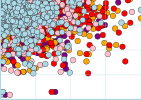

In [44]:
plt.show()

In [30]:
df[!,:Y]

1200-element Array{Float64,1}:
 -0.3998807415497072 
 -1.6396148332745462 
  0.2976499080766945 
  1.5778811335062015 
  0.29462586208767977
 -0.5306789468788021 
  0.7648630332877324 
  0.15172407456239714
 -0.42151993652041686
  0.9820152596198806 
 -1.8611772183925084 
  0.7588997938371526 
 -1.388622224382711  
  ⋮                  
 -0.1993764498280283 
  0.8774406258543507 
 -1.2308572108149651 
 -1.9052478266826365 
 -0.7131033116639203 
 -1.1195867340002716 
 -2.0156460428677168 
  1.1828233105906236 
  0.35632171742018987
  1.4874847314368245 
 -1.3356730128833099 
 -0.817236078336688  

In [45]:
x = [5,10,15,20]
y = [5,10,15,20]

4-element Array{Int64,1}:
  5
 10
 15
 20

In [47]:
plg = plot(x,y,shapes[1])

#34 (generic function with 1 method)

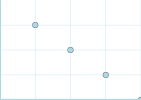

In [48]:
plg.show()

# Performance Metrics
With any good demonstration in machine-learning or computer-science, it's always important to consider performance. For these performance metrics we're going to be using @time, a function exported from IJulia to replace %timeit for IPython.

In [59]:
df = DataFrame(:X => randn(1000000), :Y => randn(1000000))

1000000×2 DataFrame
│ Row     │ X         │ Y         │
│         │ Float64   │ Float64   │
├─────────┼───────────┼───────────┤
│ 1       │ -1.72457  │ 1.37358   │
│ 2       │ -1.50125  │ -1.11363  │
│ 3       │ -0.456092 │ 1.25215   │
│ 4       │ -1.11384  │ -1.57061  │
│ 5       │ 0.285703  │ 1.10091   │
│ 6       │ 0.10011   │ -0.399535 │
│ 7       │ -0.215098 │ 1.7312    │
│ 8       │ -0.327916 │ -1.08177  │
│ 9       │ -2.40455  │ 1.69482   │
│ 10      │ -0.16908  │ -0.771437 │
⋮
│ 999990  │ -0.402854 │ 0.412746  │
│ 999991  │ -0.582896 │ 0.145992  │
│ 999992  │ -0.817382 │ 0.62428   │
│ 999993  │ -0.488121 │ -0.235974 │
│ 999994  │ -0.346492 │ 0.417363  │
│ 999995  │ 0.311879  │ -0.49049  │
│ 999996  │ 0.29379   │ -1.08417  │
│ 999997  │ -0.203964 │ -0.116738 │
│ 999998  │ -2.27954  │ -0.608406 │
│ 999999  │ -0.13013  │ 0.625865  │
│ 1000000 │ 0.567863  │ 0.449373  │

In [50]:
function LinearRegression(x,y)
    # a = ((∑y)(∑x^2)-(∑x)(∑xy)) / (n(∑x^2) - (∑x)^2)
    # b = (x(∑xy) - (∑x)(∑y)) / n(∑x^2) - (∑x)^2
    if length(x) != length(y)
        throw(ArgumentError("The array shape does not match!"))
    end
    # Get our Summations:
    Σx = sum(x)
    Σy = sum(y)
    # dot x and y
    xy = x .* y
    # ∑dot x and y
    Σxy = sum(xy)
    # dotsquare x
    x2 = x .^ 2
    # ∑ dotsquare x
    Σx2 = sum(x2)
    # n = sample size
    n = length(x)
    # Calculate a
    a = (((Σy) * (Σx2)) - ((Σx * (Σxy)))) / ((n * (Σx2))-(Σx^2))
    # Calculate b
    b = ((n*(Σxy)) - (Σx * Σy)) / ((n * (Σx2)) - (Σx ^ 2))
    # The part that is super struct:
    predict(xt) = (xt = [i = a + (b * i) for i in xt])
    (test)->(a;b;predict)
    end

LinearRegression (generic function with 1 method)

In [52]:
function LinearRegressionD(x,y)
    # a = ((∑y)(∑x^2)-(∑x)(∑xy)) / (n(∑x^2) - (∑x)^2)
    # b = (x(∑xy) - (∑x)(∑y)) / n(∑x^2) - (∑x)^2
    if length(x) != length(y)
        throw(ArgumentError("The array shape does not match!"))
    end
    # Get our Summations:
    Σx = sum(x)
    Σy = sum(y)
    # dot x and y
    xy = x .* y
    # ∑dot x and y
    Σxy = sum(xy)
    # dotsquare x
    x2 = x .^ 2
    # ∑ dotsquare x
    Σx2 = sum(x2)
    # n = sample size
    n = length(x)
    # Calculate a
    a = (((Σy) * (Σx2)) - ((Σx * (Σxy)))) / ((n * (Σx2))-(Σx^2))
    # Calculate b
    b = ((n*(Σxy)) - (Σx * Σy)) / ((n * (Σx2)) - (Σx ^ 2))
    # The part that is super struct:
    (test)->(a;b;predict)
end

LinearRegressionD (generic function with 1 method)

In [54]:
mutable struct LinReg
    x
    y
end

In [57]:
predict(m::LinReg,xt) = lin_predict(m,xt)

predict (generic function with 2 methods)

In [65]:
function lin_predict(m,xt)
    if length(x) != length(y)
        throw(ArgumentError("The array shape does not match!"))
    end
    # Get our Summations:
    Σx = sum(x)
    Σy = sum(y)
    # dot x and y
    xy = x .* y
    # ∑dot x and y
    Σxy = sum(xy)
    # dotsquare x
    x2 = x .^ 2
    # ∑ dotsquare x
    Σx2 = sum(x2)
    # n = sample size
    n = length(x)
    # Calculate a
    a = (((Σy) * (Σx2)) - ((Σx * (Σxy)))) / ((n * (Σx2))-(Σx^2))
    # Calculate b
    b = ((n*(Σxy)) - (Σx * Σy)) / ((n * (Σx2)) - (Σx ^ 2))
    (xt = [i = a + (b * i) for i in xt])
    return(xt)
end

lin_predict (generic function with 1 method)

In [60]:
using Lathe.preprocess: TrainTestSplit

In [61]:
train, test = TrainTestSplit(df)

(749686×2 DataFrame
│ Row    │ X          │ Y         │
│        │ Float64    │ Float64   │
├────────┼────────────┼───────────┤
│ 1      │ -1.72457   │ 1.37358   │
│ 2      │ -1.50125   │ -1.11363  │
│ 3      │ -0.456092  │ 1.25215   │
│ 4      │ 0.285703   │ 1.10091   │
│ 5      │ 0.10011    │ -0.399535 │
│ 6      │ -0.215098  │ 1.7312    │
│ 7      │ -0.327916  │ -1.08177  │
│ 8      │ -2.40455   │ 1.69482   │
│ 9      │ -0.16908   │ -0.771437 │
│ 10     │ -0.149323  │ -0.216598 │
⋮
│ 749676 │ -0.58412   │ -1.34118  │
│ 749677 │ -0.0821324 │ 1.24355   │
│ 749678 │ 0.523251   │ 1.37236   │
│ 749679 │ 1.7671     │ 1.37558   │
│ 749680 │ -0.285523  │ -1.18496  │
│ 749681 │ 1.25402    │ -0.899149 │
│ 749682 │ -0.488121  │ -0.235974 │
│ 749683 │ -0.346492  │ 0.417363  │
│ 749684 │ 0.311879   │ -0.49049  │
│ 749685 │ 0.29379    │ -1.08417  │
│ 749686 │ -0.203964  │ -0.116738 │, 250314×2 DataFrame
│ Row    │ X         │ Y          │
│        │ Float64   │ Float64    │
├────────┼───────────┼

In [62]:
trainX = train[:X]
trainy = train[:Y]
testX = test[:X]
testy = test[:Y]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[62]:1
└ @ Core In[62]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[62]:2
└ @ Core In[62]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[62]:3
└ @ Core In[62]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[62]:4
└ @ Core In[62]:4


250314-element Array{Float64,1}:
 -1.5706108080589776 
  0.46419470893611514
 -0.1773389021084338 
 -0.24472354055746942
 -0.7741877715560922 
 -0.4992238922577779 
 -1.8887635027197112 
  1.434578525393196  
 -1.3190760278534142 
  0.7370049055413671 
 -1.282190756809617  
  1.8572598334730703 
 -1.2632056149205835 
  ⋮                  
  0.1109938642462854 
 -0.14514632206911499
  0.6128593320617886 
  0.32997604271010916
 -0.0830490728272342 
  0.8148059852433337 
  0.4127460080759666 
  0.14599156088248247
  0.6242803512868631 
 -0.6084060158662703 
  0.6258652233477578 
  0.4493731052542983 

In [66]:
@time predict(LinReg(trainX,trainy), testX)

  0.402150 seconds (591.95 k allocations: 32.613 MiB, 5.92% gc time)


250314-element Array{Float64,1}:
 -1.1138374204565948  
  0.23765980678407142 
 -1.1837219738840723  
  0.016857621246900177
  0.29213130565156964 
  0.6981667924796754  
 -0.6352006553642048  
 -0.5003101133388637  
  0.426856590206765   
  0.35767792052123415 
 -1.1006855887216498  
 -0.5369717353259258  
  0.10686772163476589 
  ⋮                   
 -0.11889016753393694 
  0.18353513324698947 
  1.272806836666464   
 -0.4948989247430417  
  2.8565786904282446  
  0.3535241805037331  
 -0.4028543894471236  
 -0.5828964597878196  
 -0.8173817968064274  
 -2.2795383949358348  
 -0.13012975319814019 
  0.5678625509207414  

In [67]:
@time yhat = LinearRegression(trainX,trainy).predict(testX)

  0.267951 seconds (438.51 k allocations: 34.964 MiB, 4.00% gc time)


250314-element Array{Float64,1}:
  0.0017595055837036422 
 -0.0005024803512862964 
  0.001876470586472277  
 -0.00013292617978433668
 -0.0005936486954105868 
 -0.0012732257909456976 
  0.0009584165331411475 
  0.0007326517275059547 
 -0.0008191369114490068 
 -0.0007033533384782571 
  0.0017374935086477883 
  0.0007940118780243288 
 -0.0002835750875146731 
  ⋮                     
  9.42733902474554e-5   
 -0.00041189248487478796
 -0.002234994466036769  
  0.0007235950811077098 
 -0.004885735869891788  
 -0.0006964012698333401 
  0.0005695411622127833 
  0.0008708755805220281 
  0.0012633310910526582 
  0.0037105263890216257 
  0.00011308496024190494
 -0.0010551370255860973 

In [ ]:
time1 = 0.267951
time2 = 0.402150